In [24]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from TheCannon import apogee
from TheCannon import model
from TheCannon import dataset
import TheCannon
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [25]:
### wl
wl = np.genfromtxt("interpolated_wl.csv",skip_header=1)[::-1]

ID_and_flux = pd.read_csv("fluxes_for_HIRES.csv")
ivar = pd.read_csv("ivar_for_HIRES.csv")


#tr_ID
ID = ID_and_flux.columns.to_numpy()  
# #tr_flux
tr_flux = ID_and_flux.transpose().to_numpy() 
tr_ID = ID_and_flux.columns.to_numpy()
#tr_ivar
tr_ivar = ivar.to_numpy().T
#Telluric 
telluric_q = False

In [26]:
# tr_label
d = pd.read_csv("../spocData/df_all.csv", index_col=2)
for c in ["Unnamed: 0","Unnamed: 0.1",'CH','NH','OH','NaH','MgH','AlH','SiH',
          'CaH','TiH','VH','CrH','MnH','NiH','YH','DIR']:
    d.pop(c)
for i in range(22,40):
    d.pop("Unnamed: {}".format(i))

tr_label = d.to_numpy()


In [27]:
removeList = []
for i in d.index:
    test = i.replace(" ","")
    if test not in tr_ID:
        removeList.append(i)
for name in removeList:
    d = d.drop(name)     

In [28]:
index_d = d.index
index_d = np.array([i.replace(" ","") for i in index_d])
length_d = len(index_d)
restruc = []
array_d = d.to_numpy()
checking_index = 0
for i in range(len(tr_ID)):
    temp_ID = tr_ID[i-checking_index]
    loc = np.where(index_d == temp_ID)
    
    temp_list = []
    for l in array_d[loc]:
        for j in l:
            temp_list.append(float(j))
    if len(temp_list) == 0:
        tr_ID = np.delete(tr_ID,i-checking_index)
        tr_flux = np.delete(tr_flux,i-checking_index,0)
        tr_ivar = np.delete(tr_ivar,i-checking_index,0)
        checking_index+=1 
    else:
        restruc.append(temp_list)
tr_label = np.array(restruc)

In [29]:
if telluric_q: 
    t = []
    telluric = np.genfromtxt('../spocData/telluric_mask.txt')
    for i in range(len(tr_flux)):
        t.append(tr_flux[i] * telluric)
    t = np.array(t)
    tr_flux = t 

In [30]:
# Using the last 5% for testing 
RS = 32 #Random Seed # 
testing_percentage = 0.20
np.random.seed(RS)
train_ID, test_ID, tr_flux, test_flux = train_test_split(tr_ID, tr_flux, test_size = testing_percentage)
np.random.seed(RS)
tr_ID2, _, tr_ivar, test_ivar = train_test_split(tr_ID, tr_ivar, test_size = testing_percentage)
np.random.seed(RS)
tr_ID, _, tr_label, true_test_labels = train_test_split(tr_ID, tr_label, test_size = testing_percentage)

In [31]:
print("wl ",wl.shape, type(wl))
print("tr_ID ",tr_ID.shape,type(tr_ID))
print("tr_flux ",tr_flux.shape,type(tr_flux))
print("tr_ivar ",tr_ivar.shape,type(tr_ivar))
print("tr_label ",tr_label.shape,type(tr_label))

wl  (64336,) <class 'numpy.ndarray'>
tr_ID  (586,) <class 'numpy.ndarray'>
tr_flux  (586, 64336) <class 'numpy.ndarray'>
tr_ivar  (586, 64336) <class 'numpy.ndarray'>
tr_label  (586, 4) <class 'numpy.ndarray'>


In [32]:
print("wl ",wl.shape, type(wl))
print("ID ",test_ID.shape,type(test_ID))
print("flux ",test_flux.shape,type(test_flux))
print("ivar ",test_ivar.shape,type(test_ivar))
print("label ",true_test_labels.shape,type(true_test_labels))

wl  (64336,) <class 'numpy.ndarray'>
ID  (147,) <class 'numpy.ndarray'>
flux  (147, 64336) <class 'numpy.ndarray'>
ivar  (147, 64336) <class 'numpy.ndarray'>
label  (147, 4) <class 'numpy.ndarray'>


In [33]:
ds = dataset.Dataset(wl, tr_ID, tr_flux, tr_ivar, tr_label, test_ID, test_flux, test_ivar)

Loading dataset
This may take a while...


In [34]:
#ds = dataset.Dataset(wl, tr_ID, tr_flux, tr_ivar, tr_label, tr_ID, tr_flux, tr_ivar)

In [35]:
#'[C/H]','[N/H]','[O/H]','[Na/H]','[Mg/H]','[Ai/H]','[Si/H]','[Ca/H]','[Ti/H]','[V/H]',
labels = ['T_{eff}', 'log g','vsini','[Fe/H]']
ds.set_label_names(labels)

Diagnostic for SNRs of reference and survey objects


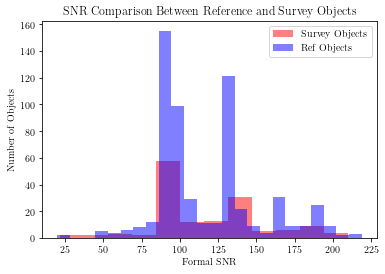

In [36]:
fig = ds.diagnostics_SNR() 

In [37]:
ds.ranges= [[min(wl),max(wl)]]

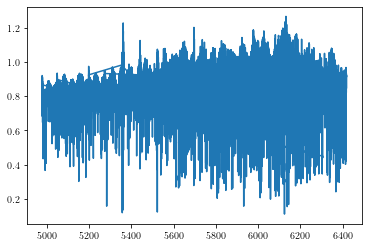

In [38]:
plt.plot(wl,tr_flux[1])
plt.show()

In [39]:
md = model.CannonModel(4, useErrors=False)
md.fit(ds)

Done training model. 


Diagnostic plot: leading coeffs and scatters across wavelength.


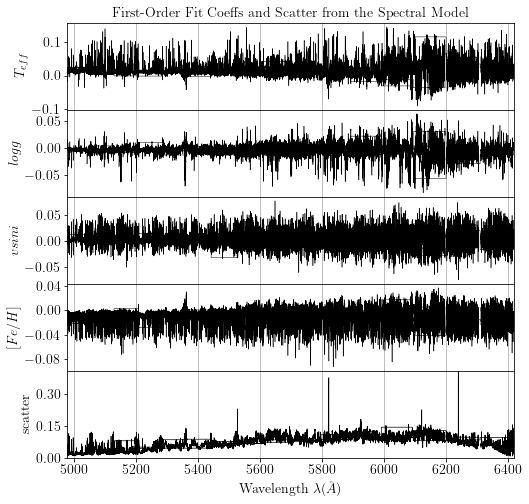

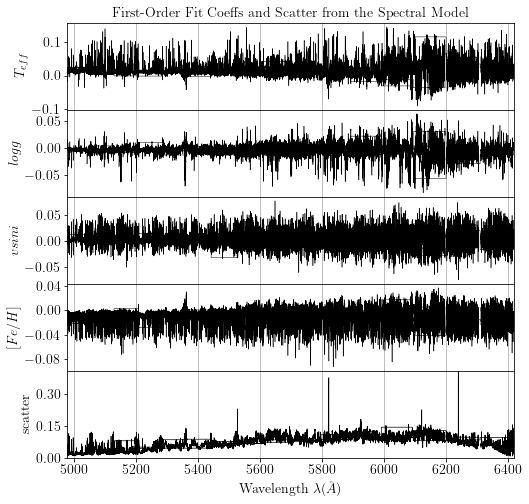

In [40]:
md.diagnostics_leading_coeffs(ds)

In [41]:
md.diagnostics_plot_chisq(ds)

Diagnostic plot: histogram of the red chi squareds of the fit
Saved as modelfit_chisqs.png


In [42]:
label_errs = md.infer_labels(ds)

Inferring Labels


In [43]:
Cannon_test_labels = ds.test_label_vals

In [44]:
from sklearn.metrics import mean_squared_error
from scipy import stats

In [45]:
#Mean-Squared Error 
results_log = pd.read_csv("TheCannonReports.csv")
results = {"# of Stars":len(tr_ID) + len(test_ID), 
           "test %" :testing_percentage *100, 
           "Seed #":RS,
           "Telluric": telluric_q,
           "MSE T_{eff}":float('-inf'),
           "MSE log g":float('-inf'),
          "MSE vsini":float('-inf'),
          "MSE [Fe/H]":float('-inf'),
          "Notes": "NA"}
for i in range(len(labels)):
    results["MSE " + labels[i]] = mean_squared_error(true_test_labels[:,i],Cannon_test_labels[:,i])

results_log = results_log.append(results,ignore_index=True)
results_log.to_csv("TheCannonReports.csv",index=False)

In [26]:
#Normalization 
for i in range(len(labels)):
    one = np.max(true_test_labels[:,i])
    two = np.max(Cannon_test_labels[:,i])
    three = max(one,two)
    Cannon_test_labels[:,i] = Cannon_test_labels[:,i]/three
    true_test_labels[:,i] = true_test_labels[:,i]/three

In [27]:
#Mean-Squared Error 
results_log = pd.read_csv("TheCannonReports.csv")
results = {"# of Stars":len(tr_ID) + len(test_ID), 
           "test %" :testing_percentage *100, 
           "Seed #":RS,
           "Telluric": telluric_q,
           "MSE T_{eff}":float('-inf'),
           "MSE log g":float('-inf'),
          "MSE vsini":float('-inf'),
          "MSE [Fe/H]":float('-inf'),
          "Notes": "NA"}
for i in range(len(labels)):
    results["MSE " + labels[i]] = mean_squared_error(true_test_labels[:,i],Cannon_test_labels[:,i])

results_log = results_log.append(results,ignore_index=True)
results_log.to_csv("TheCannonReports.csv",index=False)

In [29]:
def MakeTrueVsPredictedPlots(true_label_vals,predicted_label_vals,col_num,labels):
    '''
    
    '''
    x = true_label_vals[:,col_num]
    y = predicted_label_vals[:,col_num]
    res = stats.linregress(x, y)
    plt.plot(x, y, 'o', label='true')
    plt.plot(x, res.intercept + res.slope*x, 'r', label='Best Fit')
    plt.legend()
    plt.title(f"RS={RS},Test\%={testing_percentage}")
    plt.xlabel(f'true ${labels[col_num]}$')
    plt.ylabel(f'predicted ${labels[col_num]}$')
    plt.show()

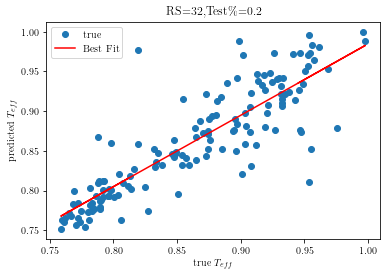

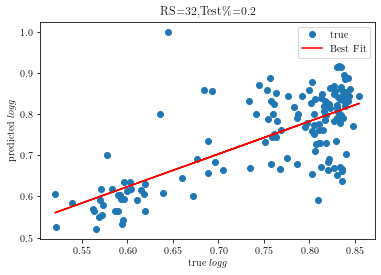

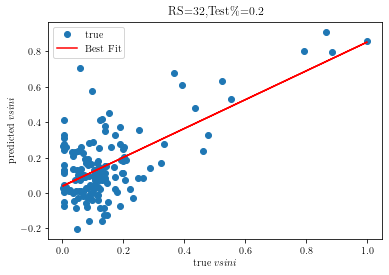

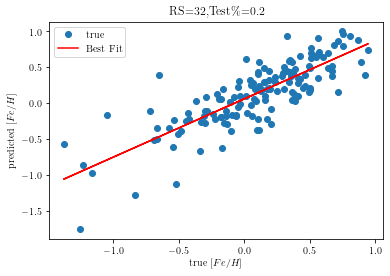

In [30]:
for i in range(len(labels)):
    MakeTrueVsPredictedPlots(true_test_labels,Cannon_test_labels,i,labels)

46574.88031978979

### TESTING BELOW 

In [60]:
#Goal: Compare compare the returned coefficients with the solar spectrum
from matplotlib.ticker import MaxNLocator

wvlen,c = np.genfromtxt("../Atlases/solarAtlas.txt",skip_header=1,usecols=(1,4),unpack=True) 
wvlen, c = np.array(wvlen[::-1]), np.array(c[::-1])

#Getting rid of lines I'm not going to use for comparison
lower_bound = np.min(wl) < wvlen
wvlen = wvlen[lower_bound]
c = c[lower_bound]
upper_bound = np.max(wl) > wvlen
wvlen = wvlen[upper_bound]
c = c[upper_bound]

Diagnostic plot: leading coeffs and scatters across wavelength.


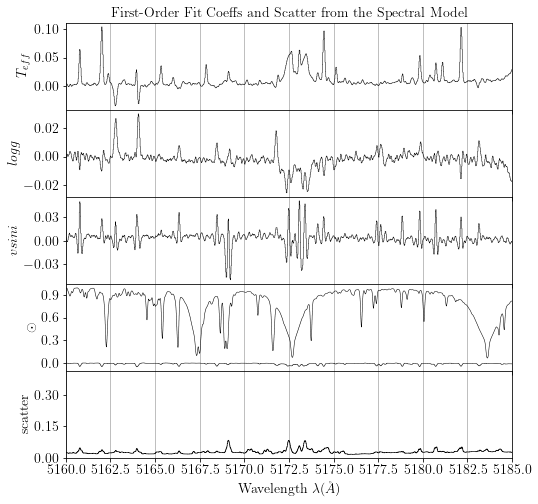

In [61]:
label_names = ds.get_plotting_labels()
lams = ds.wl
npixels = len(lams)
pivots = md.pivots
nlabels = len(pivots)
chisqs = md.chisqs
coeffs = md.coeffs
scatters = md.scatters

lower_bound = lams >5160
upper_bound = lams[lower_bound] < 5185
# Leading coefficients for each label & scatter
fig, axarr = plt.subplots(nlabels+1, figsize=(8,8), sharex=True)
ax1 = axarr[0]
plt.subplots_adjust(hspace=0.001)
nbins = len(ax1.get_xticklabels())
for i in range(1,nlabels+1):
    axarr[i].yaxis.set_major_locator(
            MaxNLocator(nbins=nbins, prune='upper'))
plt.xlabel(r"Wavelength $\lambda (\AA)$", fontsize=14)
plt.xlim(5160, 5185)
plt.tick_params(axis='x', labelsize=14)
axarr[0].set_title(
        "First-Order Fit Coeffs and Scatter from the Spectral Model",
        fontsize=14)
axarr[0].locator_params(axis='x', nbins=10)
first_order = np.zeros((len(coeffs[:,0]), nlabels))
for i in range(0, nlabels):
    ax = axarr[i]
    lbl = r'$%s$'%label_names[i]
    ax.set_ylabel(lbl, fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.xaxis.grid(True)
    y = coeffs[:,i+1]
    first_order[:, i] = y
    ax.step(lams[lower_bound][upper_bound], y[lower_bound][upper_bound], where='mid', linewidth=0.5, c='k')
    ax.locator_params(axis='y', nbins=4)

#Solar Start
lower_bound_s = wvlen >5160
upper_bound_s = wvlen[lower_bound_s] < 5185
lbl = '$\odot$'
ax.set_ylabel(lbl, fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.xaxis.grid(True)
y = c
ax.step(wvlen[lower_bound_s][upper_bound_s], y[lower_bound_s][upper_bound_s], where='mid', linewidth=0.5, c='k')
ax.locator_params(axis='y', nbins=4)
#Solar End 

ax = axarr[nlabels]
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel("scatter", fontsize=14)
top = np.max(scatters[scatters < 0.8])
stretch = np.std(scatters[scatters < 0.8])
ax.set_ylim(0, top + stretch)
ax.step(lams[lower_bound][upper_bound], scatters[lower_bound][upper_bound], where='mid', c='k', linewidth=0.7)
ax.xaxis.grid(True)
ax.locator_params(axis='y', nbins=4)
print("Diagnostic plot: leading coeffs and scatters across wavelength.")